<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>CS 144 - Gene Finding</h1></center>
<center><h1>Due: Sunday, June 8th, 2025 @ 11:59pm</h1></center>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Isabela Sforcin  <br>
    Your student ID (submitter): Ialve001
<br>
<br>
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
<br>    
<br>
<b>Instruction for submissions:</B> when you have completed this project, download this .ipynb file to your computer by left-clicking on the file name, and submit to <a href="https://elearn.ucr.edu/">Canvas</A> by the deadline. 
<br>
<br>
<B>Late work:</B> There is no late deadline for the final project, except for the most serious circumstances (illness, medical emergency, etc.) which have to be documented.
</div>


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Gene finding in the BD genome</h1></center>
<br>

The objective of this project is to find genes in a real genome (called BD) by analyzing real RNA-Seq data. The <i>BD</i> genome sequence is not available, and as far as I know, nobody knows where the genes are. <i>BD</i> is an a infectious parasite that causes a disease in human similar to Lyme disease. Both diseases are transmitted to humans through the bite of an infected tick. Finding the genes in <i>BD</i>  is crucial in our efforts to develop new drugs to prevent this parasite from harming humans.

The genome assembly of <i>BD</i> was assembled in my lab from Pacific Bioscence HiFi reads, the latest technology for DNA sequencing. We believe that <i>BD</i> has four/five chromosomes, but we are not sure yet. The assembly is currently broken up into nine contigs, some of which could be complete chromosomes but we are not sure either. The RNA-Seq reads are Pacific Bioscence IsoSeq, which is the latest third-generation sequencing technology to generate full-length cDNA sequences to characterize transcript isoforms across an entire transcriptome.

This project is somewhat open-ended, and is suitable only for students who is willing to invest more time that the other projects. Other than having fun working with a real research problem, your ideas could generate a new method in bioinformatics (i.e., this is as close to research as you will get in this class). In order to discover the genes you will have to come up with your own algorithm. You can discuss your initial idea with me, but you will responsible to justify your design choices. Your algorithm has to run in a reasonable amount of time (at least on the smallest BD chromosome) so that you can demonstrate it during the demo.

I will provide you with our best guess where the genes are, so that you compare the results on your method against our gene predictions.

First, let's get the data using wget. The file `BD.fa` is the genome (in FASTA format), while the file `transcripts.fastq` contains the transcripts (FASTQ format). Please run the code below only once or you will end up with a lot of copies of these files.

In [12]:
!wget http://www.cs.ucr.edu/~stelo/cs144/data/BD.fa
!wget http://www.cs.ucr.edu/~stelo/cs144/data/transcripts.fastq

--2025-06-06 14:02:13--  http://www.cs.ucr.edu/~stelo/cs144/data/BD.fa
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7485275 (7.1M)
Saving to: ‘BD.fa.1’

BD.fa.1             100%[===================>]   7.14M  --.-KB/s    in 0.07s   

2025-06-06 14:02:13 (101 MB/s) - ‘BD.fa.1’ saved [7485275/7485275]

--2025-06-06 14:02:13--  http://www.cs.ucr.edu/~stelo/cs144/data/transcripts.fastq
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185603909 (177M)
Saving to: ‘transcripts.fastq.1’

transcripts.fastq.1 100%[===================>] 177.00M   109MB/s    in 1.6s    

2025-06-06 14:02:15 (109 MB/s) - ‘transcripts.fastq.1’ saved [185603909/185603909]



Let's take a quick look at the content of these files using `head`. You can also use the JupyterLab Launcher to open a terminal, navigate to the directory where these files are located and type `less transcripts.fastq` or `less BD.fa`. Observe that the genome is in FASTA format (read this <A href="https://en.wikipedia.org/wiki/FASTA_format">link</A> for a description) while the transcripts are in FASTQ format (read this <A href="https://en.wikipedia.org/wiki/FASTQ_format">link</A> for a description). You can use Biophyton to parse FASTA or FASTQ. Observe that the trascripts have quality scores.

In [2]:
!head BD.fa

>contig1
CCAGACTTGCCCTCCAATTGATACTCTGGAAGGGGTTTGGATTCCCATCATTCCAATTAC
AAAGCTTTAAGCCCTGTATTGTTATTTCTTGTCACTACCTCACGGTGTCCGTATTGGGTA
ATTTGCGCGCCTGCTGCCTTCCTTAGATGTGGTAGCCGTTTCTCAGGCTCCCTCTCCGGA
ATCGAACCCTAATTCCCCGTTACCCGTCGCTGCCCCGGTAGGCCAATACCCTACCGTCCA
AAGCTGATAGGTCAGAAACTTGAATGAACCATCGCCGGCAAAAGCCATGCGATTCGCAAA
TTTATTATGAATCACCGAGTACCGCAAGCGGGAAGGTTTCGAGTCTAATAAACGCAGCCA
AGACAGGAGCCAAGGCCTCGAGCATGTATTAGCCCTACAATTAGCACGGTTATCCATGTA
AAAACGACTTTCAAATAAACTATAACTGTTGTAATGAGCCATTCGCAGTTTCACCATATA
AAAGTTTATACTTAGACATGCATGGCTTAATCTTTAAGACAAGCATATGACTACTGGCAG


In [3]:
!head transcripts.fastq

@UnnamedSample_HQ_transcript/0
GACTCGGAATAAAATGCCAAGTGATGCATTTGCCGATATTTTGTAAAAATGGTCATGAATTTGGTTCAAGCTTCACATTCGCTGCAAACTAAATGAAGGATTCCGTTTTTTCATTAAAGGATACCTCAAAGGTTCCTACAAGTGAGGAAAACCTTGAAAAGTACTGTAGCATATTAAAACGATTACAATCAGATTCTCTAGGCAATAGTATTAACAGTAGCAATATCAAATTTCAACAAGGTGATCCTGGATATACAGGACTTCCACCTCGAGTGAATGAGGAGAAAATTGTAACCATTGAAATTGAACGTTGTAGAATCTCTTTAACATTTCTAAAGCGGCTACTGACAAGTAATGAAGATGCTTCCATTGGTATTCTAACACGTGTGTTGTGTGATGATGAAATTATATCAAAATTGCTTGCATGCGGAAAGAATTTTAAATTGGGGCTTGTTAGAGATTTACCTGATGATATCAATGCTGATTTATCACAGGCCATTAAGGACGCTACTGAGGTCTTTAATGGTCAATTGATACCATTTGTAATGTGGCCTGGTAGCAATTTTAAAGTTGACCAATCTGTGGTTTTTGATGCCTTGCAGATTTACAGGCTTTTAAAATTTAATCGCAGCATATTCGTTGAAGTTGGACGCAATGTTGCCTTTTCACACGACCAAGGTGGTCCAATTGCGGTGGATTTATCCAATCCATTTATTCTTCAGGAATTGGCGGATGTAATTTTGGATGAATTATTGGCATCCCTTGAATGCCTTCAACTCTTGGCGGTTAATTGTATGAACTTTACAGATGGAACCTTGGCAATGCATTGTAAATCCATTTTAGTGCAACAGGATTTTCCCGAAATGTTATGGAACTTGTACAAGGCTCTTGACAATTTTGATCGTTTAAAAAATTTGCAAGGAATGGATCCTAAAATGACATCCATGTATATTGTGTATGTTGAACGTA

Next, we will use `minimap2` to map the reads/trascripts against the BD genome. We are using a spliced alignment for high quality reads (option `-ax splice:hq`), we are forcing `minimap2` to consider the forward transcript strand only (option `-u f`), we are using twenty CPU cores (option `-t 20`). `Minimap2` generates the index (based on the BWT) on the fly, and maps over 46 thousand transcripts in less than 5 seconds. `Minimap2` (like all the other read mappers) generates a Sequence Alignment Map (`.sam`) file, which is a text file formatted according to <A HREF="https://samtools.github.io/hts-specs/SAMv1.pdf">these specifications</A>. 

In [13]:
!minimap2 -ax splice:hq -uf -t 20 ./BD.fa ./transcripts.fastq  > ./minimap2.sam

[M::mm_idx_gen::0.308*1.00] collected minimizers
[M::mm_idx_gen::0.355*3.33] sorted minimizers
[M::main::0.355*3.33] loaded/built the index for 9 target sequence(s)
[M::mm_mapopt_update::0.393*3.10] mid_occ = 29
[M::mm_idx_stat] kmer size: 15; skip: 5; is_hpc: 0; #seq: 9
[M::mm_idx_stat::0.422*2.96] distinct minimizers: 2248355 (95.00% are singletons); average occurrences: 1.116; average spacing: 2.933
[M::worker_pipeline::3.558*13.33] mapped 46135 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax splice:hq -uf -t 20 ./BD.fa ./transcripts.fastq
[M::main] Real time: 3.573 sec; CPU: 47.433 sec; Peak RSS: 1.169 GB


We can convert the SAM file `minimap2.sam` into an equivalent binary file (`.bam`) file, which is more space efficient and can be sorted by genomic position. We will be using the tool `samtools` to (1) convert from SAM to BAM, then (2) sort the BAM file, and finally (3) index the BAM file so that we can achieve efficient access. The `.sam` file can be deleted after we get the `bam` file.

In [14]:
!samtools view -S -bT ./BD.fa ./minimap2.sam > ./minimap2.bam
!samtools sort -o ./minimap2sorted.bam ./minimap2.bam
!samtools index ./minimap2sorted.bam
!rm -f ./minimap2.sam

We will be using <A HREF="https://pysam.readthedocs.io/en/latest/index.html">PYASM</A> to process the BAM file. Let's first inspect the header files. The header is represented as a Python dictionary (where the key is the record_type). As there can be several instances of the same record_type, the value of the dictionary is a list (where each element is, again, a dictionary, or sometimes a string containing tag/value pairs). Here we are interested in capturing the name of the chromosomes/contigs (field SN), and their length (field LN).

In [2]:
import pysam
bam = pysam.AlignmentFile('minimap2sorted.bam', 'rb')
headers = bam.header
chromosome_name = []
chromosome_length = []
for record_type, records in headers.items():
    # print (record_type) # uncomment to see the records
    for i, record in enumerate(records):
        if type(record) == dict:
            # print('\t%d' % (i + 1)) # uncomment to see the records
            for field, value in record.items():
                # print('\t\t%s\t%s' % (field, value)) # uncomment to see the records
                if (field=='SN'):
                    chromosome_name.append(value)
                if (field=='LN'):
                    chromosome_length.append(value)

#print()
print('contigs =', chromosome_name)
print('lengths (bp) =', chromosome_length)

contigs = ['contig1', 'contig2', 'contig3', 'contig4', 'contig5', 'contig6', 'contig7', 'contig8', 'contig9']
lengths (bp) = [1434593, 1067697, 947309, 862326, 858812, 764930, 640591, 441379, 344845]


Next we use <A HREF="https://pysam.readthedocs.io/en/latest/index.html">PYASM</A> to compute the transcript coverage across each chromosome/contig from the BAM file produced by `minimap2`. The <i>sequencing coverage</i> (or <i>sequencing depth</i>) is defined as the number of reads (transcripts in this case) that cover a particular position in the genome. Remember that genes can be on the positive strand or the negative strand of the genome, so we need to process each strand separateraly. The purpose of the next code is to compute the arrays `coveragepositive` and `coveragenegative` for the chromosome/contig specified by the variable `c`. Below we plot the positive and negative coverage for contig9 (`c=8`).

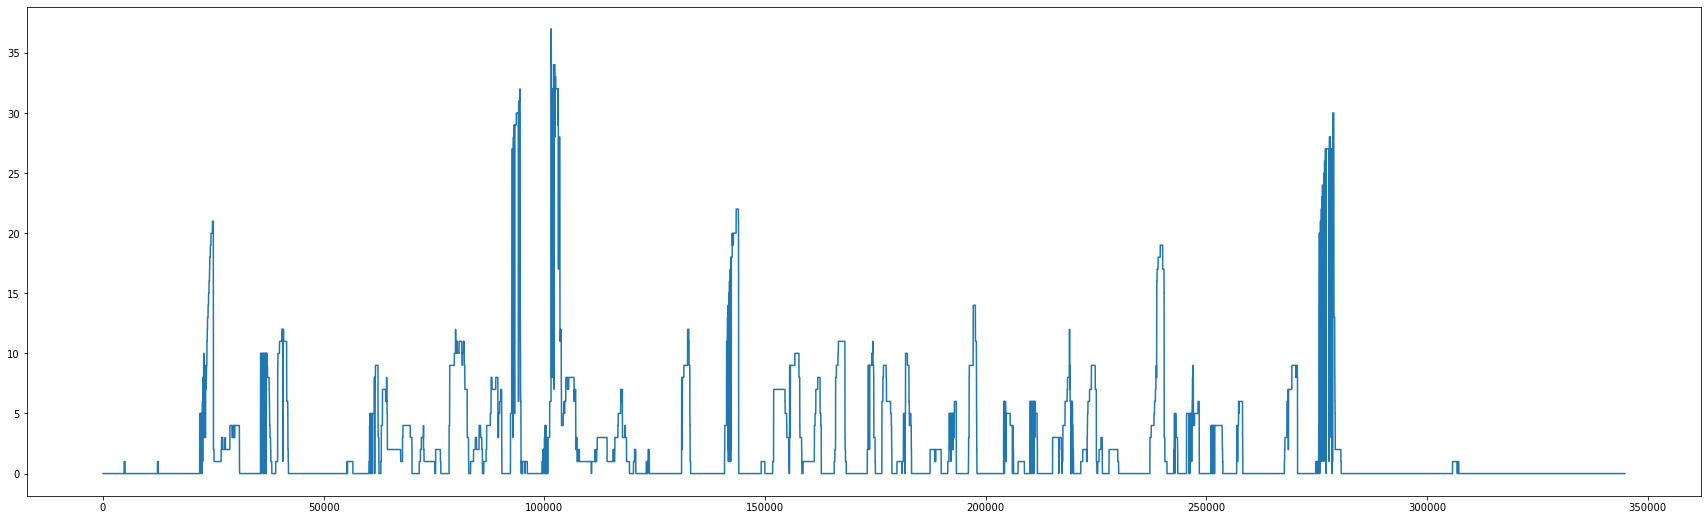

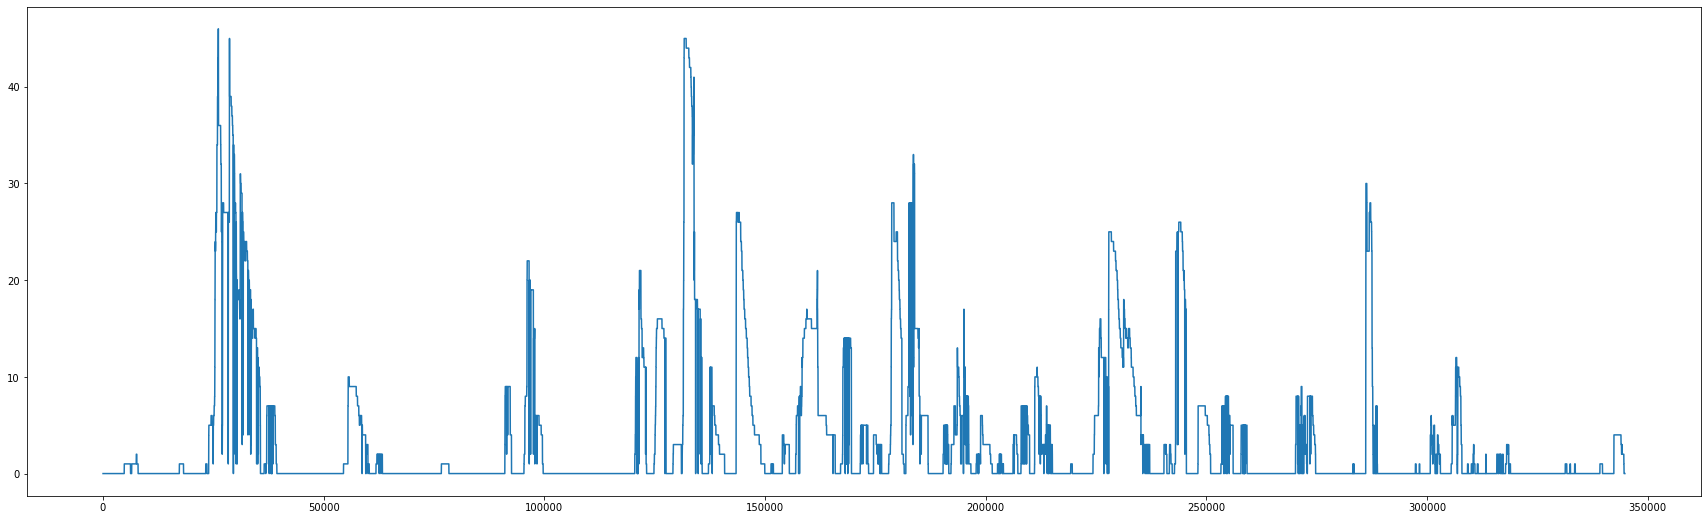

In [3]:
%matplotlib inline
import pysam
import matplotlib.pyplot as plt

minimap2 = pysam.AlignmentFile("minimap2sorted.bam", "rb" )
c = 8 # the contig we want to process; 0 is contig1, 1 is contig2, ..., 8 is contig9

# create an empty array with zeros of size chromosome_length[c]
coveragepositive = [0] * chromosome_length[c]
coveragenegative = [0] * chromosome_length[c]

# iterate over all the positions in chromosome c
for pileupcolumn in minimap2.pileup(chromosome_name[c]):  #, 24000, 24500
    positive = 0
    negative = 0
    positive_del = 0
    negative_del = 0
    # iterate over all the mapped reads that overlap that position
    for pileupread in pileupcolumn.pileups:
        if pileupread.alignment.is_reverse: # is this read mapped on the reverse strand?
            negative += 1
            # check whether the read has a deletion or an "N" in that position, if so, count it
            if pileupread.is_del and pileupread.is_refskip:
                negative_del += 1            
        else:
            positive += 1
            # check whether the read has a deletion or an "N" in that position, if so, count it
            if pileupread.is_del and pileupread.is_refskip:
                positive_del += 1     
    # the coverage is the number of reads mapped in that position minus the number of reads that have a deletion
    coveragepositive[pileupcolumn.pos] = positive - positive_del
    coveragenegative[pileupcolumn.pos] = negative - negative_del
    
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0, chromosome_length[c]), coveragepositive)
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0, chromosome_length[c]), coveragenegative)

Let's zoom in into the region (342000,344845) at the very end (telomere) of this chromosome/contig on the negative strand. This is a very clear gene on the negative strand (see below).

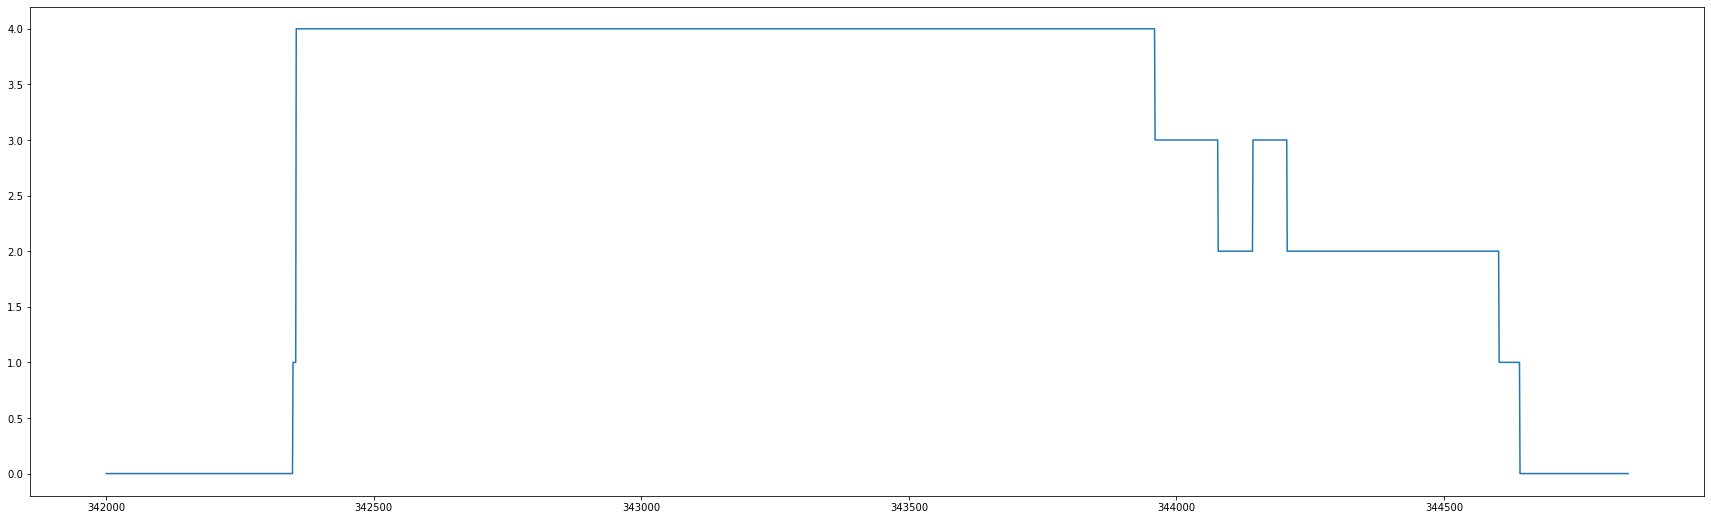

In [3]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(30,9))
begin = 342000 
end = 344845
ax.plot(range(begin, end), coveragenegative[begin:end])

The other telomeric region (21000,36000) on this chromosome/contig is more complex.

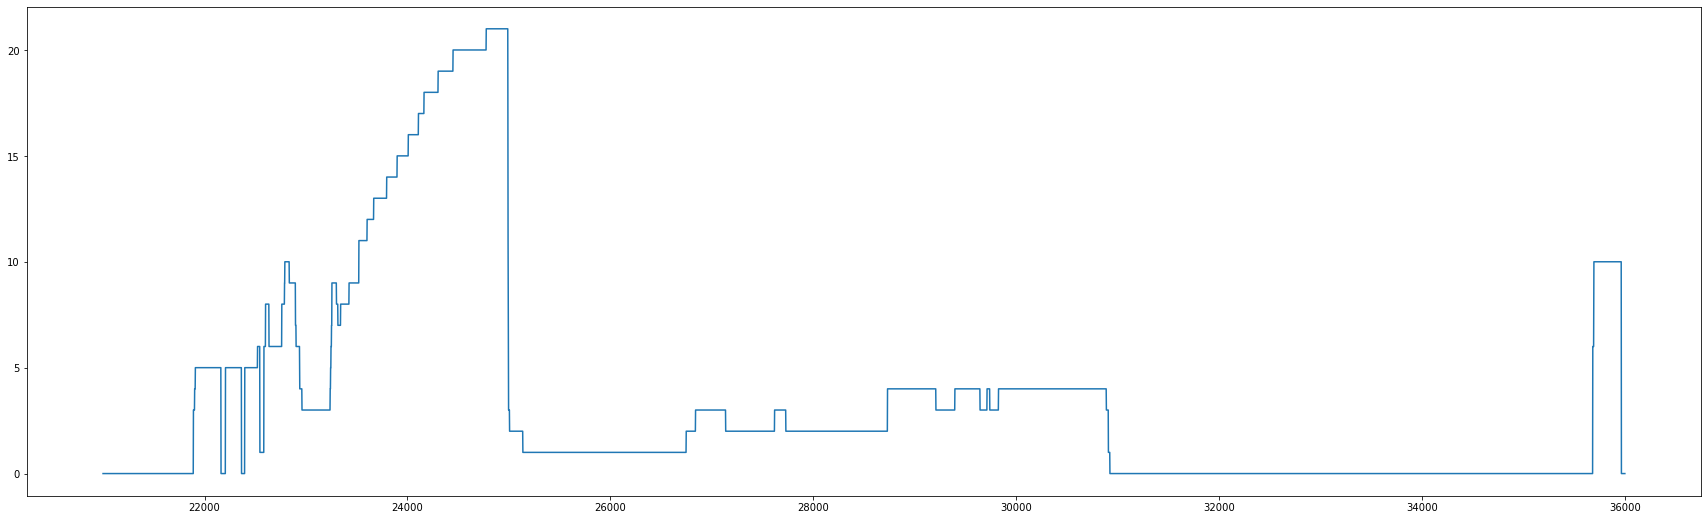

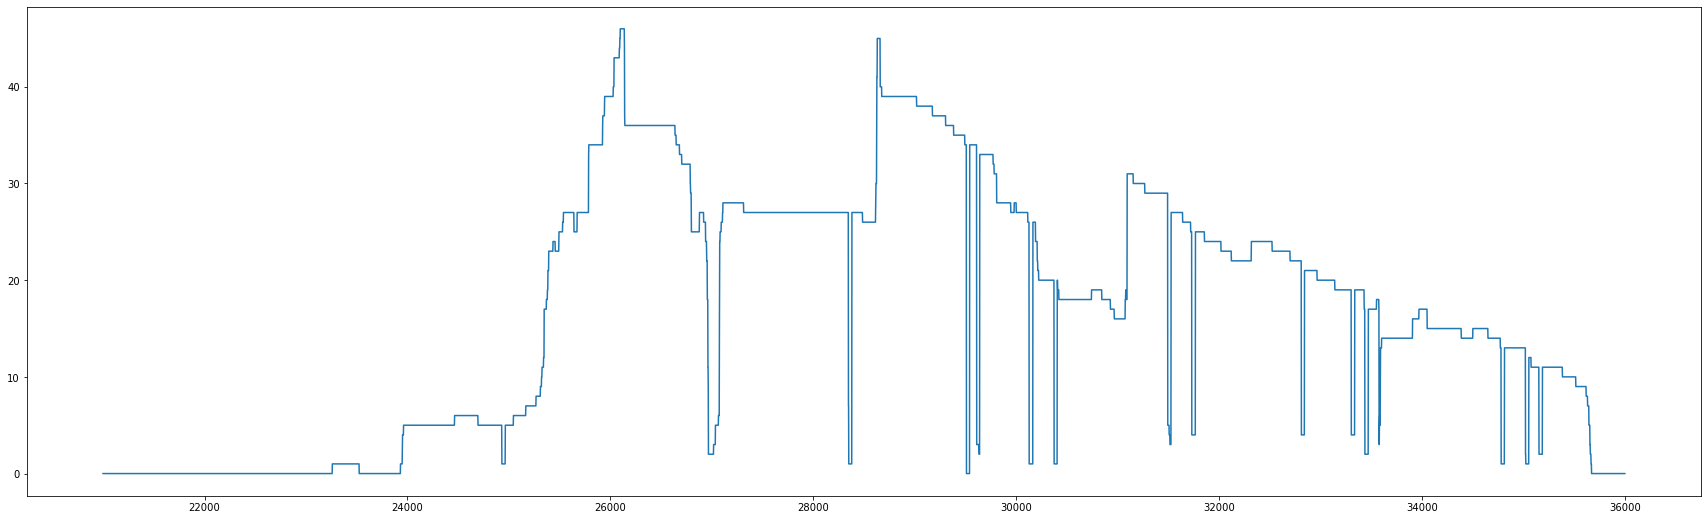

In [4]:
%matplotlib inline
begin = 21000 
end = 36000
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(begin, end), coveragepositive[begin:end])
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(begin, end), coveragenegative[begin:end])

There is a gene from position approx 21800 to  approx 30900 on the positive strand, while on the negative strand the gene is from approx 23900 to approx 35000.

The idea of this project is to use the coverage histogram to find all the genes in the BD genome. The genes in BD would correspond to genomic regions which are coveread by RNA-Seq reads (since these reads  correspond to mRNA transcripts). Note, however that the coverage can be pretty uneven, and finding the boundaries of the genes is not trivial. Coverage "valleys" inside a genome correspond to introns (which are not present in the transcript) and can confuse your algorithm.

The objective of this project is to come up with an algorithm to process the coverage histogram, and produce the list of predicted genes in the BD genome in all chromosomes/contigs. The output should a tab-separated text file with on gene per line with the format `gene_name`, `contig#`, `start`, `end`, and `strand`. Please note that `start` is always smaller than `end` even when the gene is on the negative strand. For example the following output

    BD.0001  contig1   20543    40105   -
    BD.0002  contig1   60043    65323   +
    BD.0003  contig3  133455   135034   +
    BD.0004  contig5   20344    34124   -
    ...
    
indicates that your method detected a gene `BD.0001` (the name of the gene is arbitrary) on contig1 that starts at position 20543 and ends at position 40105 on the negative strand. Gene `BD.0003` is on contig3, etc.

The position of the genes detected by our pipeline is next. You can use it to test or train your method. If you use it to train it, keep some of these data for testing.

In [5]:
!wget https://www.cs.ucr.edu/~stelo/cs144/data/genes.txt

--2025-06-08 00:57:13--  https://www.cs.ucr.edu/~stelo/cs144/data/genes.txt
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85767 (84K) [text/plain]
Saving to: ‘genes.txt.2’

genes.txt.2         100%[===================>]  83.76K  --.-KB/s    in 0.001s  

2025-06-08 00:57:13 (107 MB/s) - ‘genes.txt.2’ saved [85767/85767]



In [6]:
!head genes.txt

PB.1	contig1	91	1306	-
PB.2	contig1	7615	9514	+
PB.3	contig1	11808	13179	+
PB.4	contig1	13688	19313	+
PB.5	contig1	6353	26539	-
PB.6	contig1	29069	34410	+
PB.7	contig1	34674	35924	+
PB.8	contig1	36026	37778	+
PB.9	contig1	38677	40402	+
PB.10	contig1	41303	44207	+


In [7]:
minimap2.close()
#!rm -f minimap2* BD.* transcripts* genes.txt 2>/dev/null # uncomment this to clean up your directory

In [7]:
# BRAINSTORMING FOR PROJECT: 
#I think the best model for this owuld be a decision tree, because it will be easy to train, and it will know
#whether or not it is a gene in that region, based on the trends we find in the graph 
#in the positive strand:
#* enough coverage to cause a spike
#* there are some dips, although they don't stay at 0 for long enough to cause the end of the gene
#* also, high peaks means that it is not a gene, so we need to find the average slope, bc if it's too high we need to discard it.
# I would like to be able to implement gini index into this, but due to time contraints this will be a later development! I will continue
# working on this project during the week, and potentially present new results during demo

In [3]:
import pandas as pd
import numpy as np

# load genes.txt to extract labels
genes_df = pd.read_csv("genes.txt", sep="\t", header=None, names=["name", "contig", "start", "end", "strand"])

# convert contig name format to match what we have
genes_df["contig"] = genes_df["contig"].str.replace("contig", "")
genes_df["contig"] = genes_df["contig"].astype(int) - 1 

# c is the contig we are going to use
c = 0
coverage = coveragepositive  # just going to analyse one coverage

window_size = 20  # which will be 41

X = []
y = []

contig_genes = genes_df[genes_df["contig"] == c]

#now we just process all the positions so we can use them for our training/testing
for i in range(window_size, len(coverage) - window_size):
    if i % 1000 == 0: #i am outputting every 1000 positions as always because I like seeing it working!
        print(f"processing {i}...") #output the position every 1000

    window = coverage[i - window_size:i + window_size + 1]
    is_in_gene = 0

    for _, row in contig_genes.iterrows():
        if row["start"] <= i <= row["end"]:
            is_in_gene = 1
            break

    X.append(window)
    y.append(is_in_gene)


X = np.array(X)
y = np.array(y)

print(f"collected {len(X)} training samples")
print(f"gene labels: {sum(y)} gene, {len(y)-sum(y)} non-gene")
#from these, we will be able to find the locations of the genes, group them into their whole gene lenght, and store it like that !

Processing position 1000...
Processing position 2000...
Processing position 3000...
Processing position 4000...
Processing position 5000...
Processing position 6000...
Processing position 7000...
Processing position 8000...
Processing position 9000...
Processing position 10000...
Processing position 11000...
Processing position 12000...
Processing position 13000...
Processing position 14000...
Processing position 15000...
Processing position 16000...
Processing position 17000...
Processing position 18000...
Processing position 19000...
Processing position 20000...
Processing position 21000...
Processing position 22000...
Processing position 23000...
Processing position 24000...
Processing position 25000...
Processing position 26000...
Processing position 27000...
Processing position 28000...
Processing position 29000...
Processing position 30000...
Processing position 31000...
Processing position 32000...
Processing position 33000...
Processing position 34000...
Processing position 350

In [14]:
#just did this to process bam file for me to run the testing and training
!samtools sort minimap2.bam -o minimap2.sorted.bam
!samtools index minimap2.sorted.bam


In [4]:
import pysam
import numpy as np
import matplotlib.pyplot as plt


bamfile = pysam.AlignmentFile("minimap2.sorted.bam", "rb")


#we are going to extract the names and lenghts of the contigs
contig_names = bamfile.references
contig_lengths = bamfile.lengths

# here we are choosing which one we are going to use (i chose 1 just bc)
contig_name = "contig1"
contig_index = contig_names.index(contig_name)
chromosome_length = contig_lengths[contig_index]

# initialize the coverage arrays that we are going to use later
coveragepositive = np.zeros(chromosome_length, dtype=int)
coveragenegative = np.zeros(chromosome_length, dtype=int)

# we compute the coverages
for pileupcolumn in bamfile.pileup(contig_name):
    pos = pileupcolumn.reference_pos
    pos_coverage_pos = 0
    pos_coverage_neg = 0

    for pileupread in pileupcolumn.pileups:
        if pileupread.alignment.is_reverse:
            pos_coverage_neg += 1
        else:
            pos_coverage_pos += 1

    coveragepositive[pos] = pos_coverage_pos
    coveragenegative[pos] = pos_coverage_neg

print("coverage extracted for contig1!")
# save the coverages in the files, so we don't have to do this every time (learned it the hard way lol)
np.save("coverage_positive.npy", coveragepositive)
np.save("coverage_negative.npy", coveragenegative)

print("coverage saved to 'coverage_positive.npy' and 'coverage_negative.npy'")



[Checkpoint] Coverage extracted for contig1!
[Checkpoint] Coverage saved to 'coverage_positive.npy' and 'coverage_negative.npy'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier   #importing needed libraries to implement decision tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pysam


window_size = 61 #the side of the window we are going to analyze the data in. 20 + 20 + 1
stride = 50 #how many bases we move forward each time we move the window

# Load coverage arrays
coveragepositive = np.load("coverage_positive.npy")
coveragenegative = np.load("coverage_negative.npy")

# Load gene data
genes_df = pd.read_csv("genes.txt", sep="\t", header=None, names=["name", "contig", "start", "end", "strand"])
# convert 'contig1' to 0, etc.
genes_df["contig"] = genes_df["contig"].str.replace("contig", "")
genes_df["contig"] = genes_df["contig"].astype(int) - 1

output_file = open("predicted_genes_all_contigs.txt", "w")
model_trained = False

# Loop over each contig
for contig_index, contig_name in enumerate(pysam.AlignmentFile("minimap2.sorted.bam", "rb").references):
    print(f"\n[Processing] {contig_name}")

    coverage = coveragepositive  # using positive coverage
    chromosome_length = len(coverage)
    contig_genes = genes_df[genes_df["contig"] == contig_index] #using only the contig we are choosing earlier

    X = [] #score features
    y = [] #store labels
    positions = [] #keep track of the position of the start and end of the feature window

    print("[Checkpoint] Starting feature extraction...") #i just added this bc i wanted to see something happening to make sure code is 
    #running properly

    for i in range(0, len(coverage) - window_size, stride): #now we are going to loop thorught everything within the sliding window we chose
        if i % 10000 == 0:
            print(f" Process: position {i}") #another checkpoint to make sure it's working right 

        window = coverage[i:i + window_size]

        #VERY IMPORTANT!!
        #in this part, I am going to extract the informations I thought would be useful to decide whether or not there is a gene there
        #as i explained earlier, I believe that the mean, max and min will be good ways for the decision tree to be able to figure out if
        #there is a gene at that location or not
        features = {
            'mean': np.mean(window),
            'std': np.std(window),
            'max': np.max(window),
            'min': np.min(window),
            'center': window[len(window)//2]
        }

        #for this part, we check if there is any overlap with any existing gene, as we have the info in gene.txt
        label = 0
        for _, row in contig_genes.iterrows(): 
            if not (i + window_size < row["start"] or i > row["end"]):
                label = 1
                break

        #store the features
        X.append(list(features.values()))
        y.append(label)
        positions.append(i)

    print(f"finished extraction, {len(X)} samples found!")

    #like assignment suggested, im using 80% of the data for training, only 20% for testing
    if not model_trained:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # use the x train and y train values that we just found to train the decision tree [using library]
        model = DecisionTreeClassifier(max_depth=5, random_state=42)
        model.fit(X_train, y_train)
        print("decision tree model created !")

        #first i am going to test on only 20% of this data, then check for accuracy. 
        #it might not be too optimal to do it like this, because we don't know if the region we are splitting is going to have high 
        #quality data, or if it would be in a different position of the genome. For the purpose of this project, I will be using the same contig
        #but I will also work on testing on different contigs so I can make sure it works

        model.score(X_test, y_test)
        print("accuracy of 20% testing data model", model.score(X_test, y_test))

        model_trained = True

    predictions = model.predict(X)

    #grouping: 
    #I added this so that if there are multiple gene areas being detected, we can group them as one gene, rather than many small windows.
    #they will be grouped until the next window is not detexted as a gene 

    predicted_genes = []
    in_gene = False
    gene_start = None

    for idx, (pos, label) in enumerate(zip(positions, predictions)):
        if label == 1 and not in_gene:
            in_gene = True
            gene_start = pos
        elif label == 0 and in_gene:
            in_gene = False
            gene_end = pos + window_size
            predicted_genes.append((gene_start, gene_end))

    # edge case if the final window is a gene
    if in_gene:
        predicted_genes.append((gene_start, positions[-1] + window_size))

    print(f"[Checkpoint] Found {len(predicted_genes)} predicted genes")

    #now we just need to save the results in another file, and output!
    for i, (start, end) in enumerate(predicted_genes):
        output_file.write(f"BD.{contig_index+1:02d}.{i+1:04d}\t{contig_name}\t{start}\t{end}\t+\n")

output_file.close()
print("prediction finished, results saved to predicted_genes_all_contigs.txt ! yayyy")



[Processing] contig1
[Checkpoint] Starting feature extraction...
 Process: position 0
 Process: position 10000
 Process: position 20000
 Process: position 30000
 Process: position 40000
 Process: position 50000
 Process: position 60000
 Process: position 70000
 Process: position 80000
 Process: position 90000
 Process: position 100000
 Process: position 110000
 Process: position 120000
 Process: position 130000
 Process: position 140000
 Process: position 150000
 Process: position 160000
 Process: position 170000
 Process: position 180000
 Process: position 190000
 Process: position 200000
 Process: position 210000
 Process: position 220000
 Process: position 230000
 Process: position 240000
 Process: position 250000
 Process: position 260000
 Process: position 270000
 Process: position 280000
 Process: position 290000
 Process: position 300000
 Process: position 310000
 Process: position 320000
 Process: position 330000
 Process: position 340000
 Process: position 350000
 Process: po

In [ ]:
#sources: 
#for this project, i used https://www.geeksforgeeks.org/decision-tree-implementation-python/ 
#for the implementation of the decision tree
#this source for classification : https://scikit-learn.org/stable/modules/tree.html
#also all the sources given in this assignment for background on the data

#I utilized my notes and decision tree knowledge from my cs171 Machine Learning class. 
#For future implementations, I would like to train the model using one config, and make it generalized enough for me to be able to test
#it and run it using any other config or data sets
#I was able to achieve a 90% accuracy using the same data set for testing and training (20% was for training), but I will continue
#working on this project, as I am really interested in how I could apply different data structures or machine learning models to make 
#it generalized but precise enough ! 
#Result:
#for now, the main thing is my kernel keeps crashing. but it is working properly. I am training and testing with the same data, but I will
#update this method. It works for now, and the new implementation would not be too hard to do.

                                                                                            